# Colab Setting

In [ ]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
noteboook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code'
os.chdir(noteboook_path)

!echo -e "\nCurrent directory:"
!pwd

Mounted at /content/drive

Current directory:
/content/drive/.shortcut-targets-by-id/1yBERxWlYaZqd2aPZEzBr21t8G6McvwZA/Berkeley Capstone (Students)/Code


# Data Loading

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

## By Week

In [ ]:
week_df = pd.read_csv('./ExtractedData/weekr4.2.csv')
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1.262506e+09,1.263110e+09,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.262506e+09,1.263110e+09,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.262506e+09,1.263110e+09,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.262506e+09,1.263110e+09,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.262506e+09,1.263110e+09,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
week_df.loc[:,'starttime'] = pd.to_datetime(week_df['starttime'])
week_df.loc[:,'endtime'] = pd.to_datetime(week_df['endtime'])
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## By Day

In [ ]:
day_df = pd.read_csv('./ExtractedData/dayr4.2.csv')

# Data Processing

## Get Temporal Information

In [ ]:
from scipy import stats 

def get_features(df, removed_cols):
    x_cols = [i for i in df.columns if i not in removed_cols]
    return x_cols

def get_temporal_info(df, x_cols, level="week", window=4, method='Percentile'):
    output = pd.DataFrame(columns=[level, 'user','insider']+x_cols)

    for t in trange(window+1, df[level].max()+1):
      X = df[df[level].isin([w for w in range(t-window, t)])]
      x_t = df[df[level]==t]
      user_list = set(X.user.tolist()).intersection(set(x_t.user.tolist()))

      for user in user_list:
        X_u = X[X.user == user]
        xt_u = x_t[x_t.user == user]
        xt_output = [t, user, xt_u.insider.values[0]]

        if method == 'Percentile':
            for feature in x_cols:
              pct = stats.percentileofscore(X_u[feature].values, xt_u[feature].values)
              xt_output.append(pct)
        else:
            xt_u_list = xt_u.reset_index().loc[0, x_cols].tolist()
            if method == 'Median Difference':
                X_u_list = X_u.groupby("user").median().reset_index().loc[0, x_cols].tolist()
                diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
            elif method == 'Mean Difference':
                X_u_list = X_u.groupby("user").mean().reset_index().loc[0, x_cols].tolist()
                diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
            xt_output = xt_output + diff

        output = output.append(dict(zip(output.columns,xt_output)), ignore_index=True)
    
    return output

## Split Dataset

In [ ]:
def split_dataset(data, x_cols):
  
    data1stHalf = data[data.week <= max(data.week)/2]
    dataTest = data[data.week > max(data.week)/2]

    selectedTrainUsers =  set(data1stHalf[data1stHalf.insider > 0]['user'])
    nUsers = np.random.permutation(list(set(data1stHalf.user) - selectedTrainUsers))
    trainUsers = np.concatenate((list(selectedTrainUsers), nUsers[:200-len(selectedTrainUsers)]))

    unKnownTestUsers = list(set(dataTest.user) - selectedTrainUsers)
    
    xTrain = data1stHalf[data1stHalf.user.isin(trainUsers)][x_cols].values
    yTrain = data1stHalf[data1stHalf.user.isin(trainUsers)]['insider'].values
    yTrainBin = yTrain > 0
    # Wenqi: Test dataset not the validation dataset
    xTest = dataTest[dataTest.user.isin(unKnownTestUsers)][x_cols].values
    yTest = dataTest[dataTest.user.isin(unKnownTestUsers)]['insider'].values
    yTestBin = yTest > 0

    X = np.concatenate((xTrain, xTest))
    yBin = np.concatenate((yTrainBin, yTestBin))
    
    return X, yBin, xTrain, yTrainBin, xTest, yTestBin

In [ ]:
# window = 4
# method = 'Percentile' #['Percentile', 'Mean Difference', 'Median Difference']
# removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']

# feature_names = get_features(week_df, removed_cols)
# temp_info_df = get_temporal_info(week_df, feature_names, level="week", window=window, method=method)
# X, yBin, xTrain, yTrainBin, xTest, yTestBin = split_dataset(temp_info_df, feature_names)

100%|██████████| 68/68 [2:21:37<00:00, 124.97s/it]


In [ ]:
# temp_info_df.to_csv('Percentile.csv', index = False)

removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']
feature_names = get_features(week_df, removed_cols)
temp_info_df = pd.read_csv('Percentile.csv')
X, yBin, xTrain, yTrainBin, xTest, yTestBin = split_dataset(temp_info_df, feature_names)

# Score

In [ ]:
from sklearn.metrics import roc_curve, auc, recall_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
def acu_curve(y, prob):
    
    fpr, tpr, threshold = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, 
             tpr, 
             color = 'darkorange',
             lw = 2, 
             label = 'ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

# Model

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def RandomForestModel(verbose=1):

    param_rf = {'n_estimators': [100, 200, 300, 500],
                'max_depth': [4, 6, 8, 10]}

    return RandomForestClassifier(), param_rf

## XGBoost

In [ ]:
import xgboost as xgb

def XGBoostModel():

    param_xgb = {'max_depth': [4, 6, 8, 10],
                 'n_estimators': [100, 200, 300, 400, 500],
                 'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
                 'subsample': [0.3, 0.5, 0.7, 0.9]}

    return xgb.XGBClassifier(booster='gbtree', scale_pos_weight=15, eval_metric='auc'), param_xgb

## LSTM

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

def IsolationForestModel():
    IF = IsolationForest(n_estimators=200, 
                         max_samples=256)
    IF.fit(xTest)
    IF_score = IF.decision_function(xTest)
    print('Detection rate at different budgets:')
    for ib in [0.001, 0.01, 0.05, 0.1, 0.2]:
        threshold = np.percentile(IF_score, 100*ib)
        flagged = np.where(IF_score<threshold)[0]
        dr = sum(yTestBin[flagged]>0)/sum(yTestBin>0)
        print(f'{100*ib}%, DR = {100*dr:.2f}%')

## AutoEncoder

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import paired_distances
from sklearn.preprocessing import StandardScaler

def AutoEncoderModel(xTrain):
    
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)

    l = len(feature_names)
    ae = MLPRegressor(hidden_layer_sizes = (int(l/4), int(l/8), int(l/4)),
                      activation = 'tanh',
                      max_iter = 50, 
                      random_state = 10)

    ae.fit(xTrain, xTrain)
    reconstructionError = paired_distances(xTrain, ae.predict(xTrain))
    return reconstructionError

# Unsupervised Baseline

In [ ]:
def investigation(yBin, score, budgets, ret):
    threshold = np.percentile(score, 100-100*budgets)
    flagged = np.where(score <=threshold)[0]
    yIB = yBin.copy()
    yIB[flagged] = 0
    if not ret:
        dr = sum(yIB)/sum(yBin)
        return dr
    else:
        return yIB

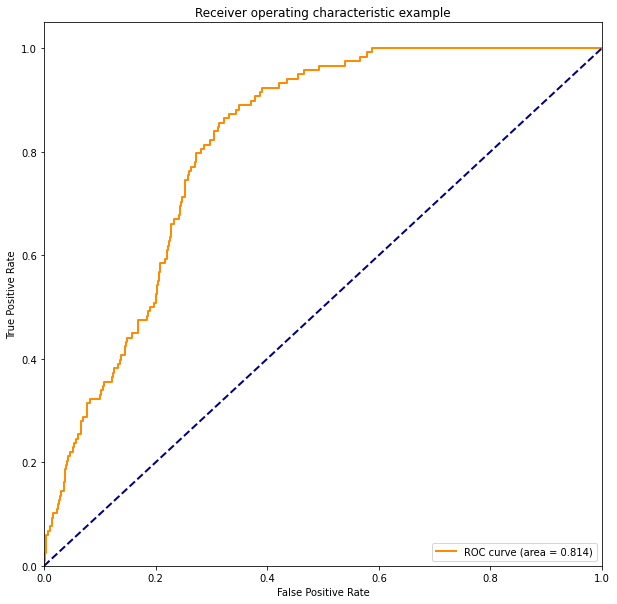

In [ ]:
AE_baseline = AutoEncoderModel(xTrain)
acu_curve(yTrainBin, AE_baseline)

In [ ]:
AE_baseline_dr = []
for ib in [0.001, 0.01, 0.05, 0.1]:
    dr = investigation(yTrainBin, AE_baseline, ib, ret = False)
    AE_baseline_dr.append(dr)
    print(f'{100*ib}%, DR = {100*dr:.2f}%')
    

0.1%, DR = 1.69%
1.0%, DR = 6.78%
5.0%, DR = 22.03%
10.0%, DR = 32.20%


# Unsupervised Investigation Budget 

In [ ]:
AE_IB = AutoEncoderModel(xTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Validation

In [ ]:
from sklearn.metrics import recall_score, classification_report, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV, TimeSeriesSplit

def ML_train(ML_model, ML_hyper, XTrain, yTrain):
    
    RS = RandomizedSearchCV(
        ML_model, 
        ML_hyper, 
        n_iter = 5,
        refit = "f1_macro",
        cv = TimeSeriesSplit(), 
        # scoring=["f1_macro", "f1_micro","roc_auc", "precision", "recall"],
        scoring = ["f1_macro", "f1_micro"],
        random_state = 0)

    RS.fit(XTrain, yTrain)

    print('Best Parameters:')
    print(RS.best_params_)

    return RS

# Testing

In [ ]:
def prediction(ML_model, xTest, yBin, yTrainIB):

    # ML model pred
    y_ML_pred = ML_model.predict(xTest)
    # Consider the first Unsupervised model part
    y_pred = np.concatenate((yTrainIB, y_ML_pred))
    report = classification_report(yBin, y_pred, output_dict=True)

    return report['True']
    # return recall_score(yBin, y_pred)

    # y_score = ML_model.predict_proba(xTest)
    # acu_curve(yTest, pd.DataFrame(y_score)[1])

In [ ]:
from collections import defaultdict

RF_pred = defaultdict(list)
XGB_pred = defaultdict(list)

for i, ib in tqdm(enumerate([0.002, 0.02, 0.1, 0.2])):
    yTrainIB = investigation(yTrainBin, AE_IB, ib, ret = True)

    RF = ML_train(RandomForestModel()[0], RandomForestModel()[1], xTrain, yTrainIB)
    XGB = ML_train(XGBoostModel()[0], XGBoostModel()[1], xTrain, yTrainIB)

    RF_metrics = prediction(RF, xTest, yBin, yTrainIB)
    XGB_metrics = prediction(XGB, xTest, yBin, yTrainIB)
    for key, values in RF_metrics.items():
      RF_pred[key].append(values)
    for key, values in XGB_metrics.items():
      XGB_pred[key].append(values)

0it [00:00, ?it/s]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 6, 'colsample_bytree': 0.7}


1it [02:34, 154.29s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 4, 'colsample_bytree': 0.9}


2it [05:44, 175.22s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'colsample_bytree': 0.3}


3it [08:54, 182.03s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'colsample_bytree': 0.3}


4it [12:17, 184.41s/it]


Text(0.5, 1.0, 'F1 Score')

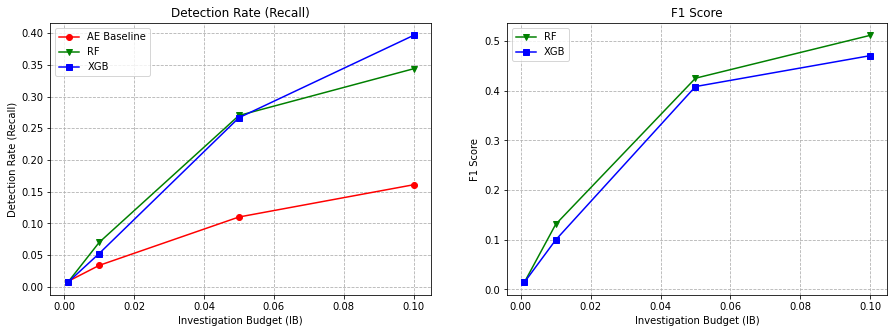

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))

plt.subplot(121)
# np.array(AE_baseline_dr)*xTrain.shape[0]/X.shape[0]
plt.plot([0.001, 0.01, 0.05, 0.1], np.array(AE_baseline_dr)/2, color = 'r', label = 'AE Baseline', marker='o')
plt.plot([0.001, 0.01, 0.05, 0.1], RF_pred["recall"], color = 'g', label = 'RF', marker='v')
plt.plot([0.001, 0.01, 0.05, 0.1], XGB_pred["recall"], color = 'b', label = 'XGB', marker='s')

plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.xlabel('Investigation Budget (IB)')
plt.ylabel('Detection Rate (Recall)')
plt.title('Detection Rate (Recall)')

plt.subplot(122)
plt.plot([0.001, 0.01, 0.05, 0.1], RF_pred["f1-score"], color = 'g', label = 'RF', marker='v')
plt.plot([0.001, 0.01, 0.05, 0.1], XGB_pred["f1-score"], color = 'b', label = 'XGB', marker='s')

plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.xlabel('Investigation Budget (IB)')
plt.ylabel('F1 Score')
plt.title('F1 Score')

In [ ]:
RF_pred

defaultdict(list,
            {'f1-score': [0.013937282229965157,
              0.13114754098360656,
              0.425414364640884,
              0.5117493472584856],
             'precision': [1.0, 1.0, 1.0, 1.0],
             'recall': [0.007017543859649123,
              0.07017543859649122,
              0.27017543859649124,
              0.34385964912280703],
             'support': [285, 285, 285, 285]})

In [ ]:
XGB_pred

defaultdict(list,
            {'f1-score': [0.013937282229965157,
              0.09966777408637874,
              0.40860215053763443,
              0.4708333333333334],
             'precision': [1.0,
              0.9375,
              0.8735632183908046,
              0.5794871794871795],
             'recall': [0.007017543859649123,
              0.05263157894736842,
              0.26666666666666666,
              0.39649122807017545],
             'support': [285, 285, 285, 285]})